# Flights' visual report
#

Here we have a data set of flights


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

In [2]:
flights=pd.read_csv('flights.csv')
flights.info()
flights.nunique()
flights.head(1)
flights.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              336776 non-null  int64  
 1   year            336776 non-null  int64  
 2   month           336776 non-null  int64  
 3   day             336776 non-null  int64  
 4   dep_time        328521 non-null  float64
 5   sched_dep_time  336776 non-null  int64  
 6   dep_delay       328521 non-null  float64
 7   arr_time        328063 non-null  float64
 8   sched_arr_time  336776 non-null  int64  
 9   arr_delay       327346 non-null  float64
 10  carrier         336776 non-null  object 
 11  flight          336776 non-null  int64  
 12  tailnum         334264 non-null  object 
 13  origin          336776 non-null  object 
 14  dest            336776 non-null  object 
 15  air_time        327346 non-null  float64
 16  distance        336776 non-null  int64  
 17  hour      

id      year          month            day       dep_time  \
count  336776.000000  336776.0  336776.000000  336776.000000  328521.000000   
mean   168387.500000    2013.0       6.548510      15.710787    1349.109947   
std     97219.001466       0.0       3.414457       8.768607     488.281791   
min         0.000000    2013.0       1.000000       1.000000       1.000000   
25%     84193.750000    2013.0       4.000000       8.000000     907.000000   
50%    168387.500000    2013.0       7.000000      16.000000    1401.000000   
75%    252581.250000    2013.0      10.000000      23.000000    1744.000000   
max    336775.000000    2013.0      12.000000      31.000000    2400.000000   

       sched_dep_time      dep_delay       arr_time  sched_arr_time  \
count   336776.000000  328521.000000  328063.000000   336776.000000   
mean      1344.254840      12.639070    1502.054999     1536.380220   
std        467.335756      40.210061     533.264132      497.457142   
min        106.000000     -43.000000       1.000000        1.000000   
25%        906.000000      -5.000000    1104.000000     1124.000000   
50%       1359.000000      -2.000000    1535.000000     1556.000000   
75%       1729.000000      11.000000    1940.000000     1945.000000   
max       2359.000000    1301.000000    2400.000000     2359.000000   

           arr_delay         flight       air_time       distance  \
count  327346.000000  336776.000000  327346.000000  336776.000000   
mean        6.895377    1971.923620     150.686460    1039.912604   
std        44.633292    1632.471938      93.688305     733.233033   
min       -86.000000       1.000000      20.000000      17.000000   
25%       -17.000000     553.000000      82.000000     502.000000   
50%        -5.000000    1496.000000     129.000000     872.000000   
75%        14.000000    3465.000000     192.000000    1389.000000   
max      1272.000000    8500.000000     695.000000    4983.000000   

                hour         minute  
count  336776.000000  336776.000000  
mean       13.180247      26.230100  
std         4.661316      19.300846  
min         1.000000       0.000000  
25%         9.000000       8.000000  
50%        13.000000      29.000000  
75%        17.000000      44.000000  
max        23.000000      59.000000

In [3]:
flights=flights.drop(['tailnum','time_hour'],axis=1)

## Data cleaning

Some required function for conversion of data types:

In [4]:
from datetime import datetime
def day_of_year(day, month):
    date_str = f'{month}-1-2023'
    date_obj = datetime.strptime(date_str, '%m-%d-%Y')
    day_of_year = date_obj.timetuple().tm_yday + day - 1
    return day_of_year


def change_to_minute_of_day( hhmm):
    mm=np.remainder(hhmm,100)
    hh=(hhmm-mm)/100
    return(60*hh+mm)

def duration_minutes(starttime_inminutes,endtime_inminutes):
    if endtime_inminutes<starttime_inminutes:
        return(24*60-starttime_inminutes+endtime_inminutes)
    else:
        return(endtime_inminutes - starttime_inminutes)
    
def add_minutes( starttime_inminutes , duration_in_minutes):
    t=starttime_inminutes+duration_in_minutes
    if t<24*60:
        return (t)
    else:
        return(t-24*60)
        
def subtract_minutes( endtime_inminutes , duration_in_minutes):
    t=endtime_inminutes-duration_in_minutes
    if t>0:
        return (t)
    else:
        return(24*60+t)

The 'year' column is redundant since it includes only 2013 year. 
Also compute day_of_year for the dates that flights are done.

In [9]:
flights=pd.read_csv('flights.csv')
print(flights.year.unique())
#flights=flights.drop('year',axis=1)

flights['dayOfYear'] = flights.apply(lambda row: day_of_year(row['day'], row['month']), axis=1)


[2013]


<p>
    The columns "dep_time, sched_dep_time ,arr_time and sched_arr_time",  seem to be integers. But they are stated in "hhmm" type in fact.
    Using "change_to_minute_of_day" function, we change them into valid integer types.
</p>
<p>
    We also have some rows that their 'arr_delay' are null and we should compute diff(arr_time, sched_arr_time) for them as much as possible.
</p>

In [6]:
df =flights
df.dep_time =change_to_minute_of_day(df.dep_time)
df.sched_dep_time = change_to_minute_of_day(df.sched_dep_time)
df.arr_time =change_to_minute_of_day(df.arr_time)
df.sched_arr_time = change_to_minute_of_day(df.sched_arr_time )

print(f" Number of null dep_delays before calculation is {len(df.loc[df.dep_delay.isnull()])}") 
df.loc[df.dep_delay.isnull() , 'arr_delay']= df.apply ( lambda row: duration_minutes( row['sched_dep_time'] , row['dep_time']) , axis=1)
print(f" Number of null dep_delays after calculation is {len(df.loc[df.dep_delay.isnull()])} \n")

print(f" Number of null arr_delays before calculation is {len(df.loc[df.arr_delay.isnull()])}")   
df.loc[df.arr_delay.isnull() , 'arr_delay']= df.apply ( lambda row: duration_minutes( row['sched_arr_time'] , row['arr_time']) , axis=1)
print(f" Number of null arr_delays after calculation is {len(df.loc[df.arr_delay.isnull()])}")   


 Number of null dep_delays before calculation is 8255
 Number of null dep_delays after calculation is 8255 

 Number of null arr_delays before calculation is 9430
 Number of null arr_delays after calculation is 8713


Now, check if we can get the null data of columns 'air_time' , 'dep_time' and 'arr_time' from each other.

In [7]:
print(f"Currently we have {len(df)} records totally.") 
print(f"Number of null air_times before calculation is {len(df.loc[df.air_time.isnull()])}")
df.loc[df.air_time.isnull()& df.dep_time.notnull() & df.arr_time.notnull() , 'air_time'] = \
            df.apply( lambda row: duration_minutes( row['dep_time'] , row['arr_time']) , axis=1 )
print(f"Number of null air_times after calculation is :{len(df[df.air_time.isnull()])}")

print( f"Number of null dep_times before calculation : {len(df[df.dep_time.isnull()])}") 
df.loc[df.dep_time.isnull() & df.air_time.notnull() & df.arr_time.notnull() , 'dep_time' ]=\
             df.apply( lambda row: subtract_minutes(row['arr_time'] , row['air_time'])  , axis=1 )
print( f"Number of null dep_times after calculation : {len(df[df.dep_time.isnull()])}")


print( f"Number of null arr_times before calculation : {len(df[df.arr_time.isnull()])}" )
df.loc[df.arr_time.isnull() & df.air_time.notnull() & df.dep_time.notnull() , 'arr_time'] = \
             df.apply( lambda row:  add_minutes(row['dep_time'] , row['air_time']) , axis=1 )
print( f"Number of null arr_times after calculation : {len(df[df.arr_time.isnull()])}" )

Currently we have 336776 records totally.
Number of null air_times before calculation is 9430
Number of null air_times after calculation is :8713
Number of null dep_times before calculation : 8255
Number of null dep_times after calculation : 8255
Number of null arr_times before calculation : 8713
Number of null arr_times after calculation : 8713


Here is a brief statistics of those triple columns which are modified:

In [8]:
print(f"Total records: {len(df)}") 
df[['arr_time' ,'dep_time' , 'air_time']].describe()

Total records: 336776


arr_time       dep_time       air_time
count  328063.000000  328521.000000  328063.000000
mean      913.020819     822.168169     151.029805
std       320.172755     292.730990      93.966221
min         1.000000       1.000000      20.000000
25%       664.000000     547.000000      82.000000
50%       935.000000     841.000000     130.000000
75%      1180.000000    1064.000000     192.000000
max      1440.000000    1440.000000    1165.000000

Definition of two new columns namely the 'speed' and 'day_of_week':

In [9]:
df['speed']= df.distance / df.air_time
df['day_of_week'] = pd.to_datetime(df[['year', 'month', 'day']]).dt.day_name() 

## Plots

The following plot shows the distribution of our two important features: 'arr_delay' and 'dep_delay'. It shows that we usually do not have too much delays. Even in the departure histogram, curtisis is seen around negative delays.This means that we frequently had departures sooner than the scheduled departure time. 

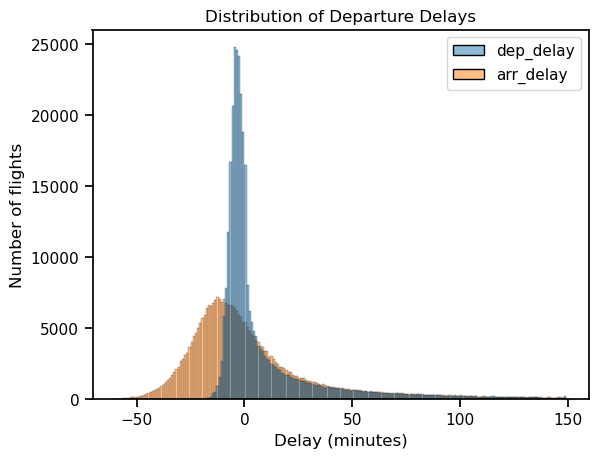

In [93]:
sns.histplot(df[['dep_delay','arr_delay']].dropna() , bins=range(-60, 150,1))
plt.xlabel('Delay (minutes)')
plt.ylabel('Number of flights')
plt.title('Distribution of Departure Delays') 
plt.show() 

In the following we see the corrolation among numerical features in our dataset in a heatmap:

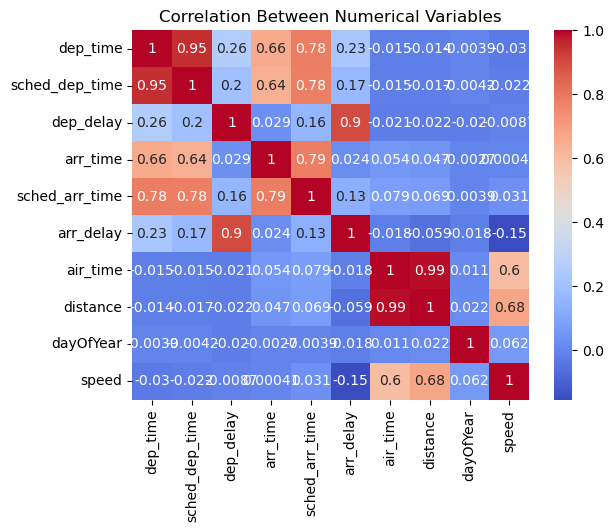

In [14]:
df2=df[['dep_time', 'sched_dep_time', 'dep_delay', 'arr_time', 'sched_arr_time', 'arr_delay','air_time', 'distance', 'dayOfYear','speed'] ]
cor=df2.corr() 
sns.heatmap(cor, cmap='coolwarm', annot=True)
plt.title('Correlation Between Numerical Variables')
plt.show()
 

As is clear, there is a strong corrolation among  arrival delay and departure delay.Our next plot shows these corrolation using a scatter plot:  

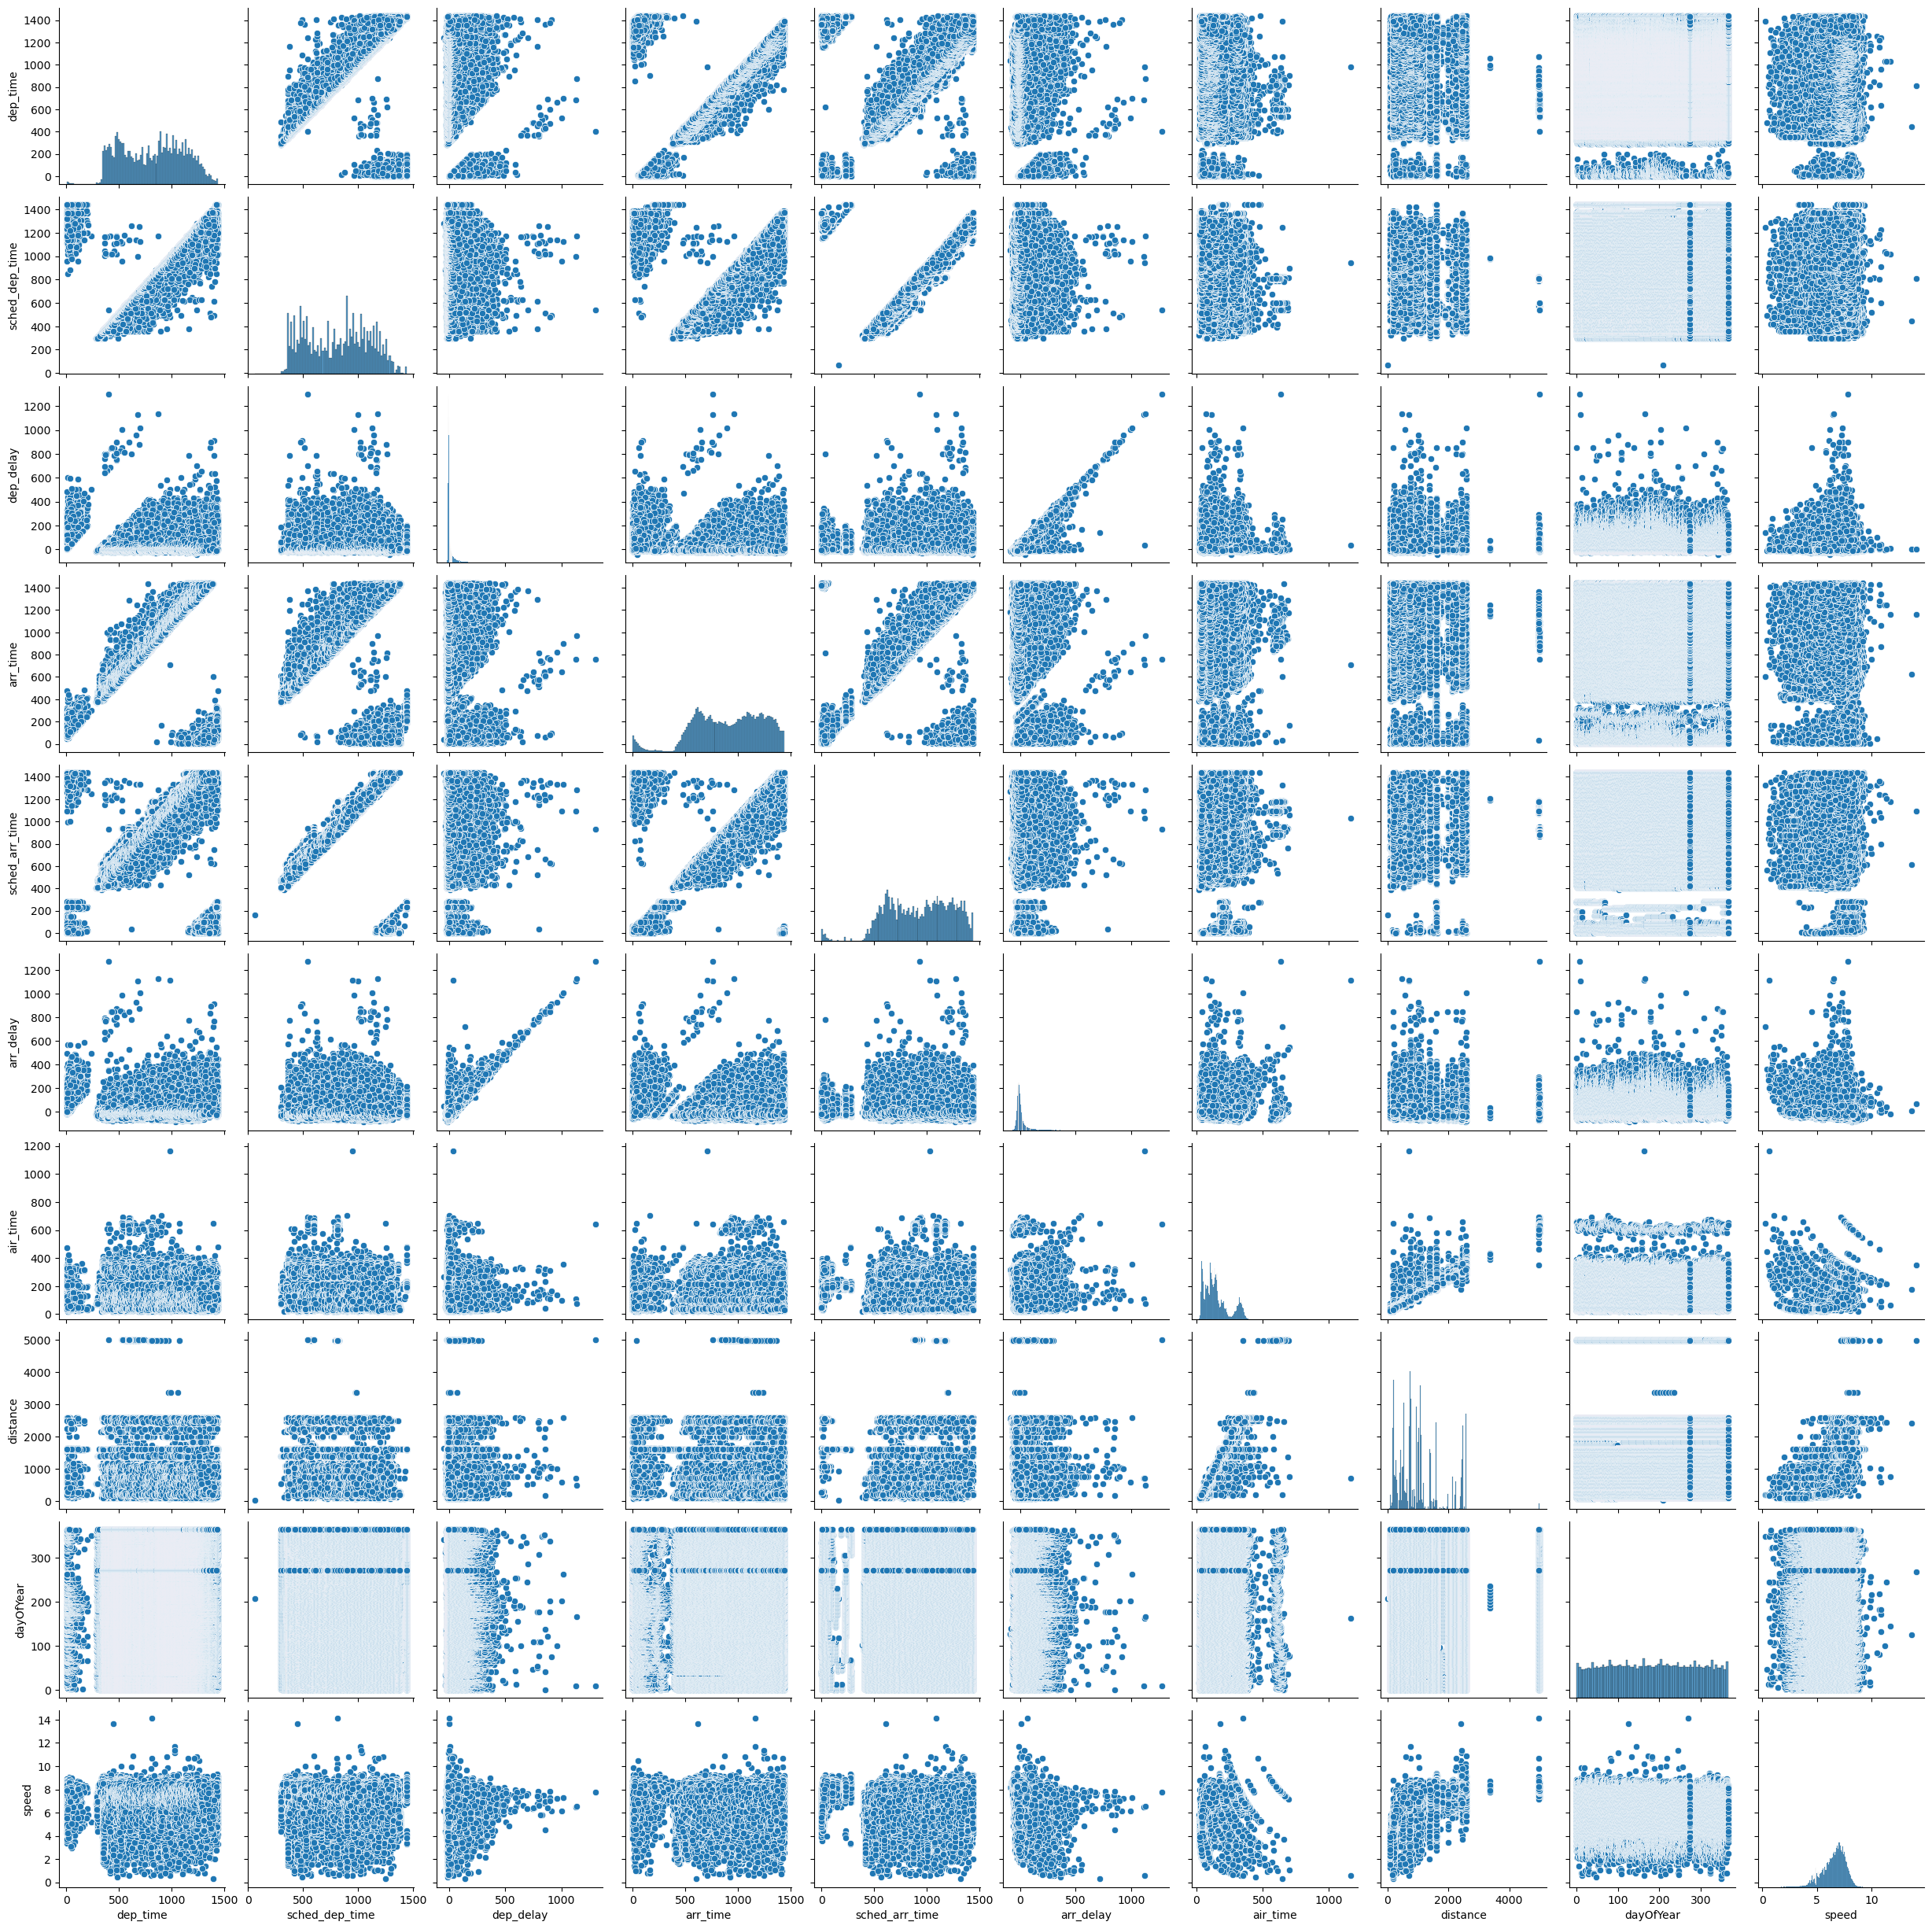

In [13]:
sns.pairplot(df2)
plt.show()

Now we want to investigate the number of flights in each carrier. The following chart show this:
    

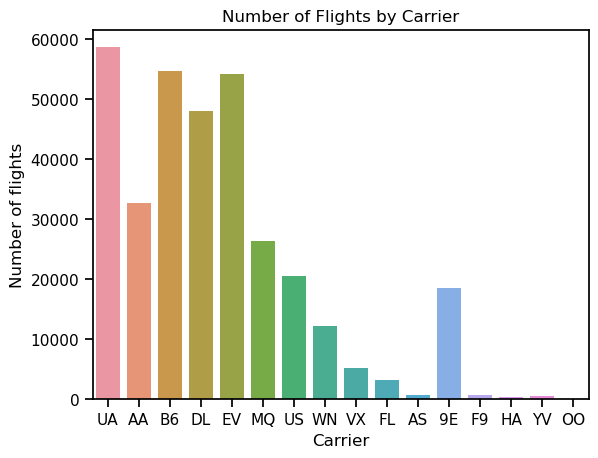

In [45]:
sns.countplot(x='carrier', data=df)
plt.xlabel('Carrier')
plt.ylabel('Number of flights')
plt.title('Number of Flights by Carrier')
plt.show()

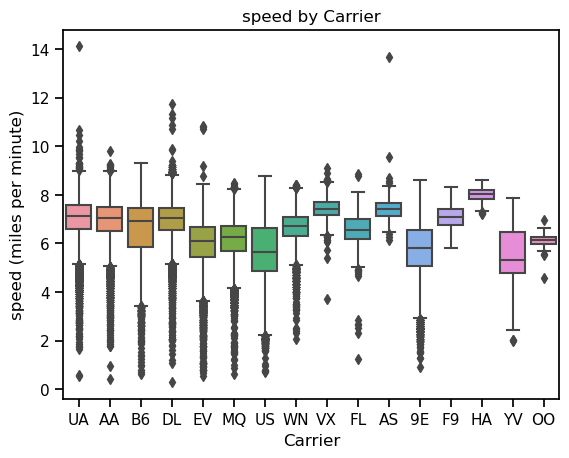

In [46]:
sns.boxplot(x='carrier', y='speed', data=df)
plt.xlabel('Carrier')
plt.ylabel('speed (miles per minute)')
plt.title('speed by Carrier')
plt.show()

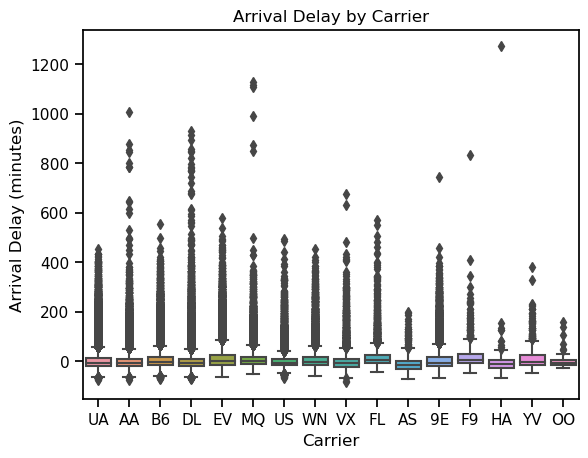

In [47]:
sns.boxplot(x='carrier', y='arr_delay', data=df)
plt.xlabel('Carrier')
plt.ylabel('Arrival Delay (minutes)')
plt.title('Arrival Delay by Carrier')
plt.show()


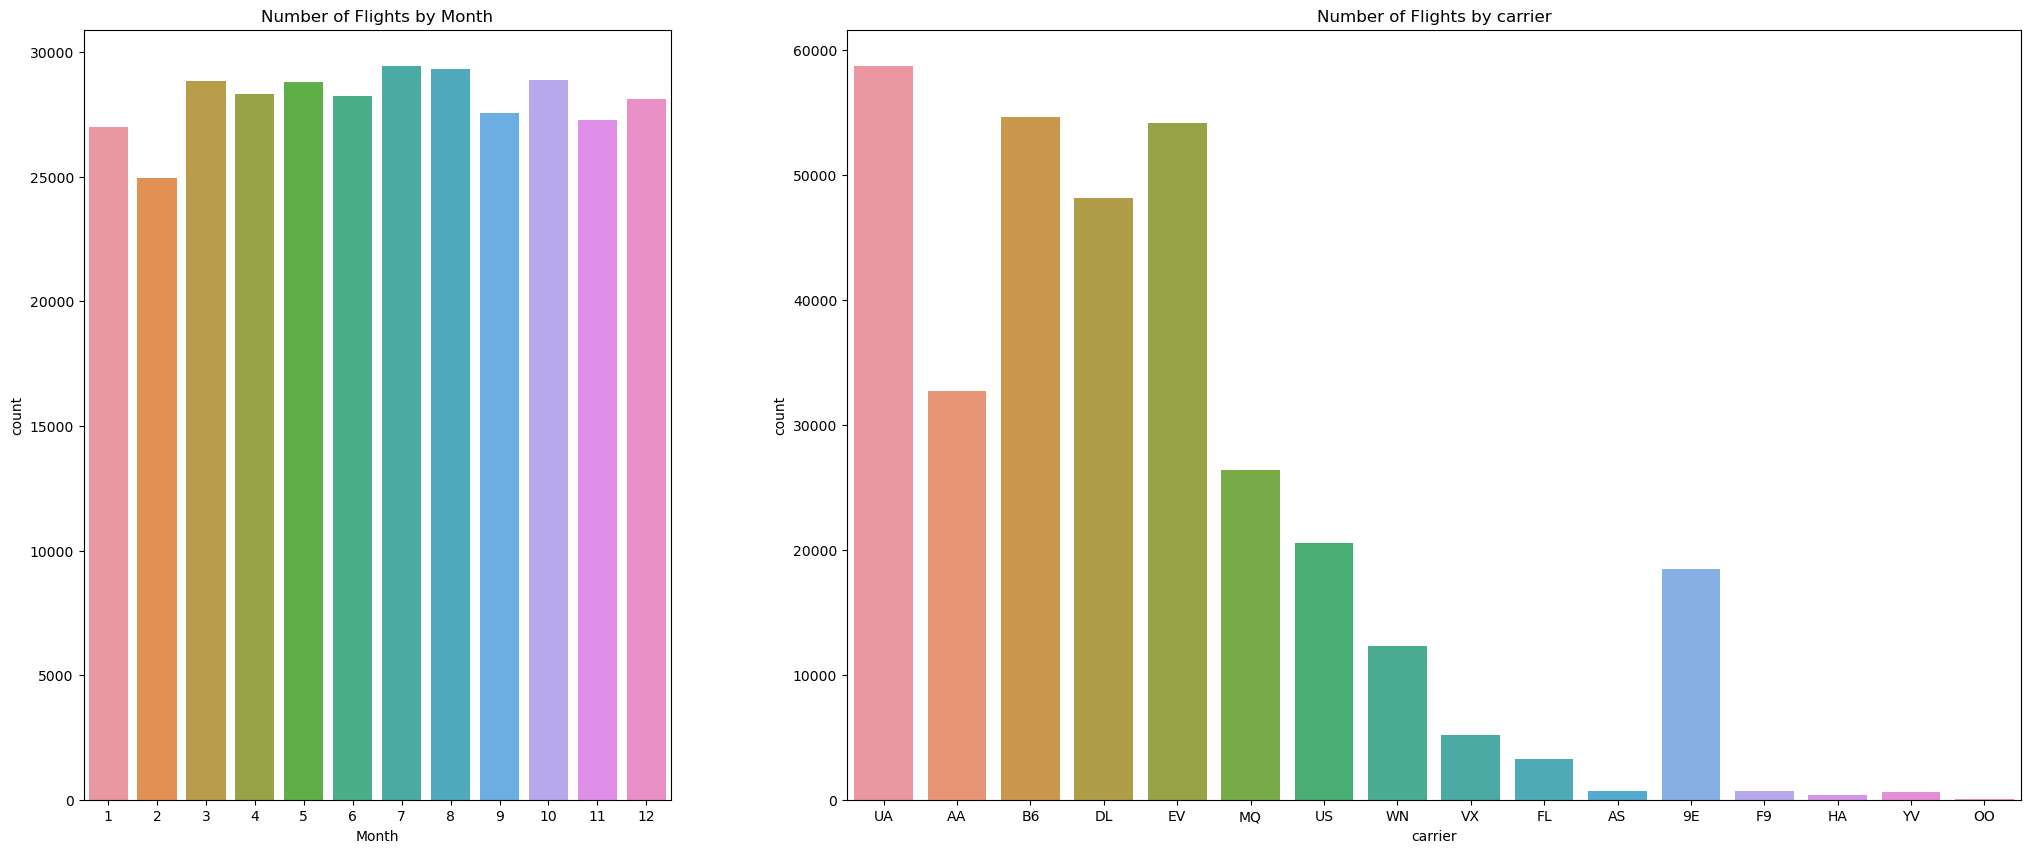

In [51]:
fig ,(ax1 , ax2)=plt.subplots(1,2 , figsize=(25,10) , width_ratios=[1,2]) 
sns.countplot(x='month', data=df , ax=ax1 ,)
ax1.set_xlabel('Month')
ax1.set_label('Number of flights')
ax1.set_title('Number of Flights by Month')
sns.countplot(x='carrier', data=df , ax=ax2)
ax2.set_label('Day')
ax2.set_label('Number of flights')
ax2.set_title('Number of Flights by carrier')
#fig.tight_layout(pad=1)
plt.show()


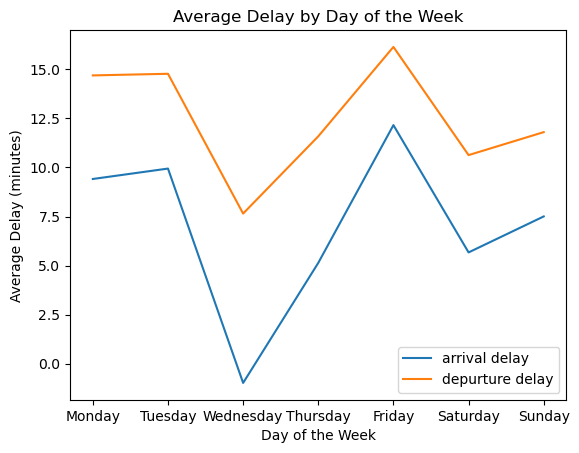

In [10]:
days =['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_delay_by_day = df.groupby('day_of_week')[['arr_delay' , 'dep_delay']].mean()

plt.plot(days, avg_delay_by_day)
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Delay by Day of the Week')
plt.legend(['arrival delay','depurture delay'])
plt.show()


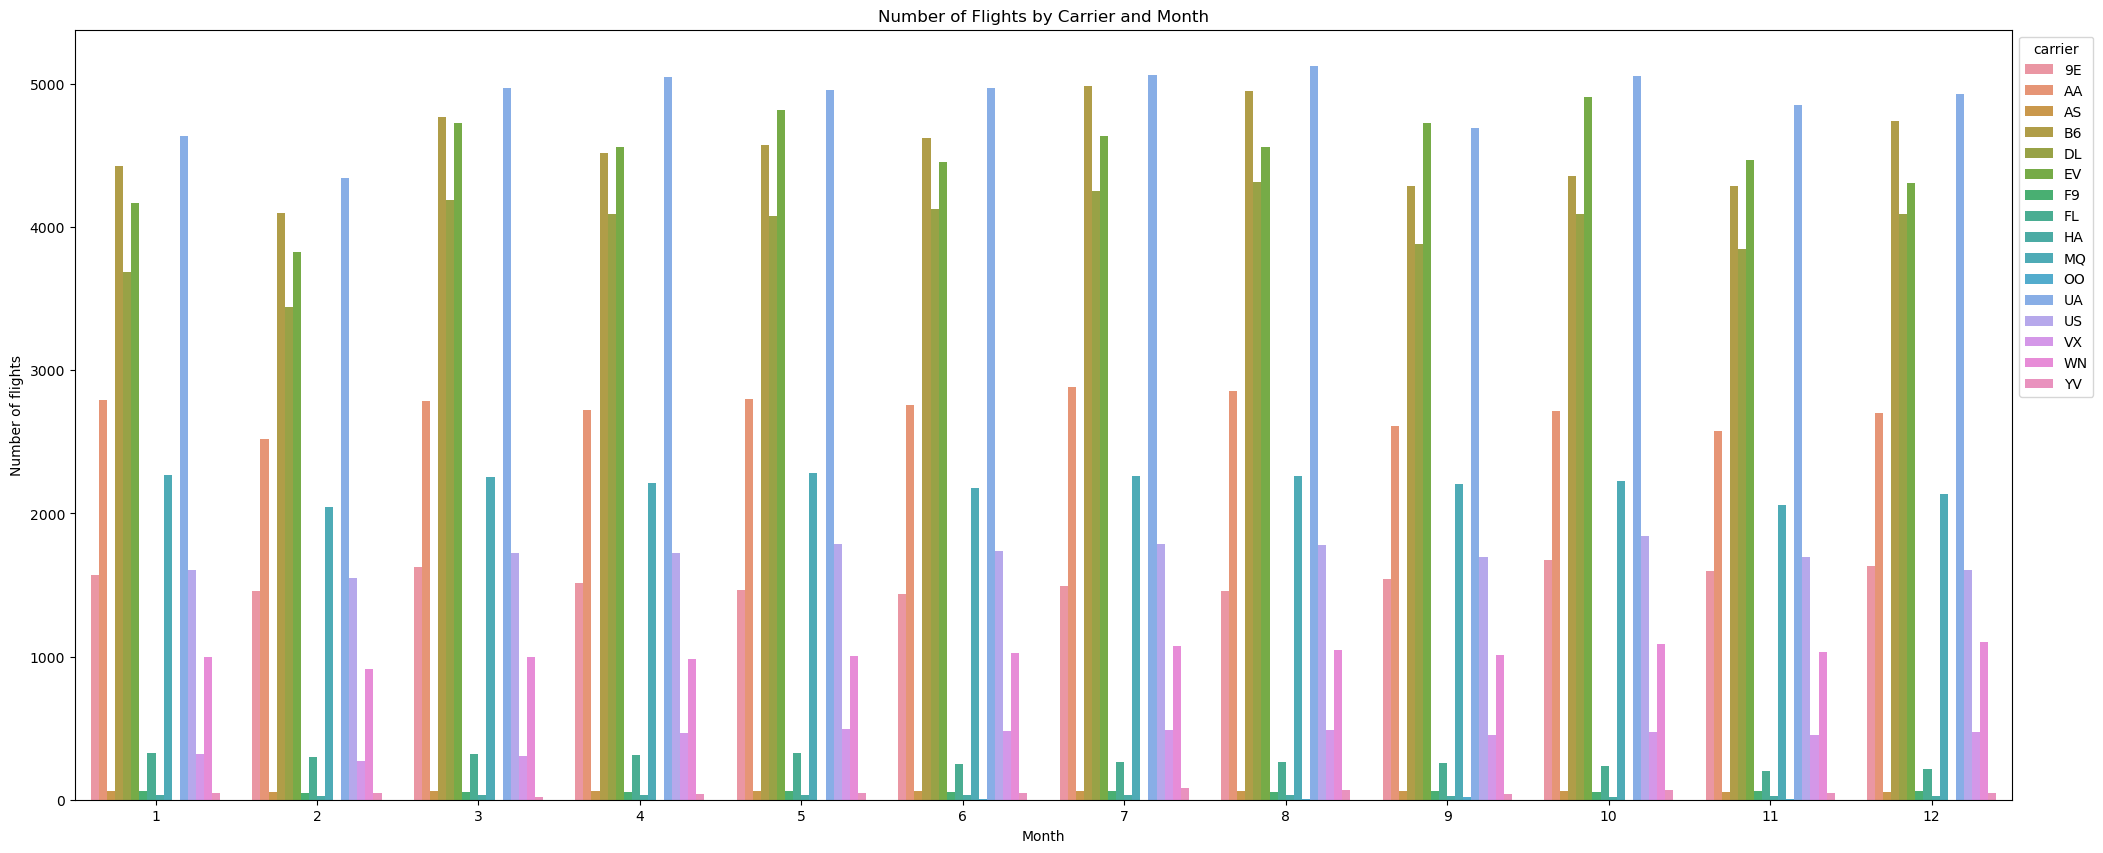

In [63]:
flights_by_carrier_month = df.groupby(['carrier', 'month'])['id'].count().reset_index()
fig,ax=plt.subplots(figsize=(25,10))
sns.barplot(x='month', y='id', hue='carrier', data=flights_by_carrier_month , ax=ax )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Month')
plt.ylabel('Number of flights')
plt.title('Number of Flights by Carrier and Month')
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_20892\175032183.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  flights_by_carrier_hour_pivot = flights_by_carrier_hour.pivot('carrier', 'hour', 'arr_delay')


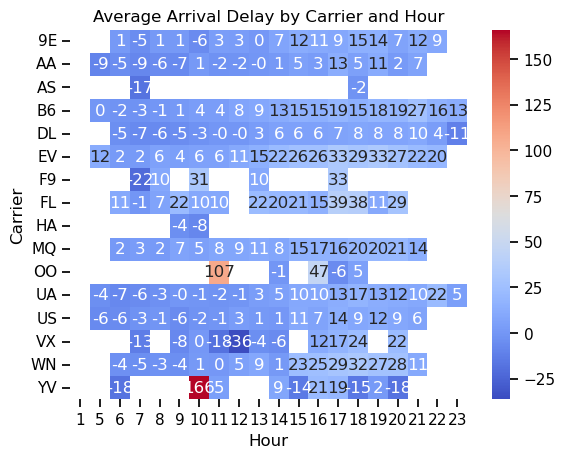

In [51]:
flights_by_carrier_hour = df.groupby(['carrier', 'hour'])['arr_delay'].mean().reset_index()
flights_by_carrier_hour_pivot = flights_by_carrier_hour.pivot('carrier', 'hour', 'arr_delay')
sns.heatmap(flights_by_carrier_hour_pivot, cmap='coolwarm', annot=True, fmt='.0f')
plt.xlabel('Hour')
plt.ylabel('Carrier')
plt.title('Average Arrival Delay by Carrier and Hour')
plt.show()


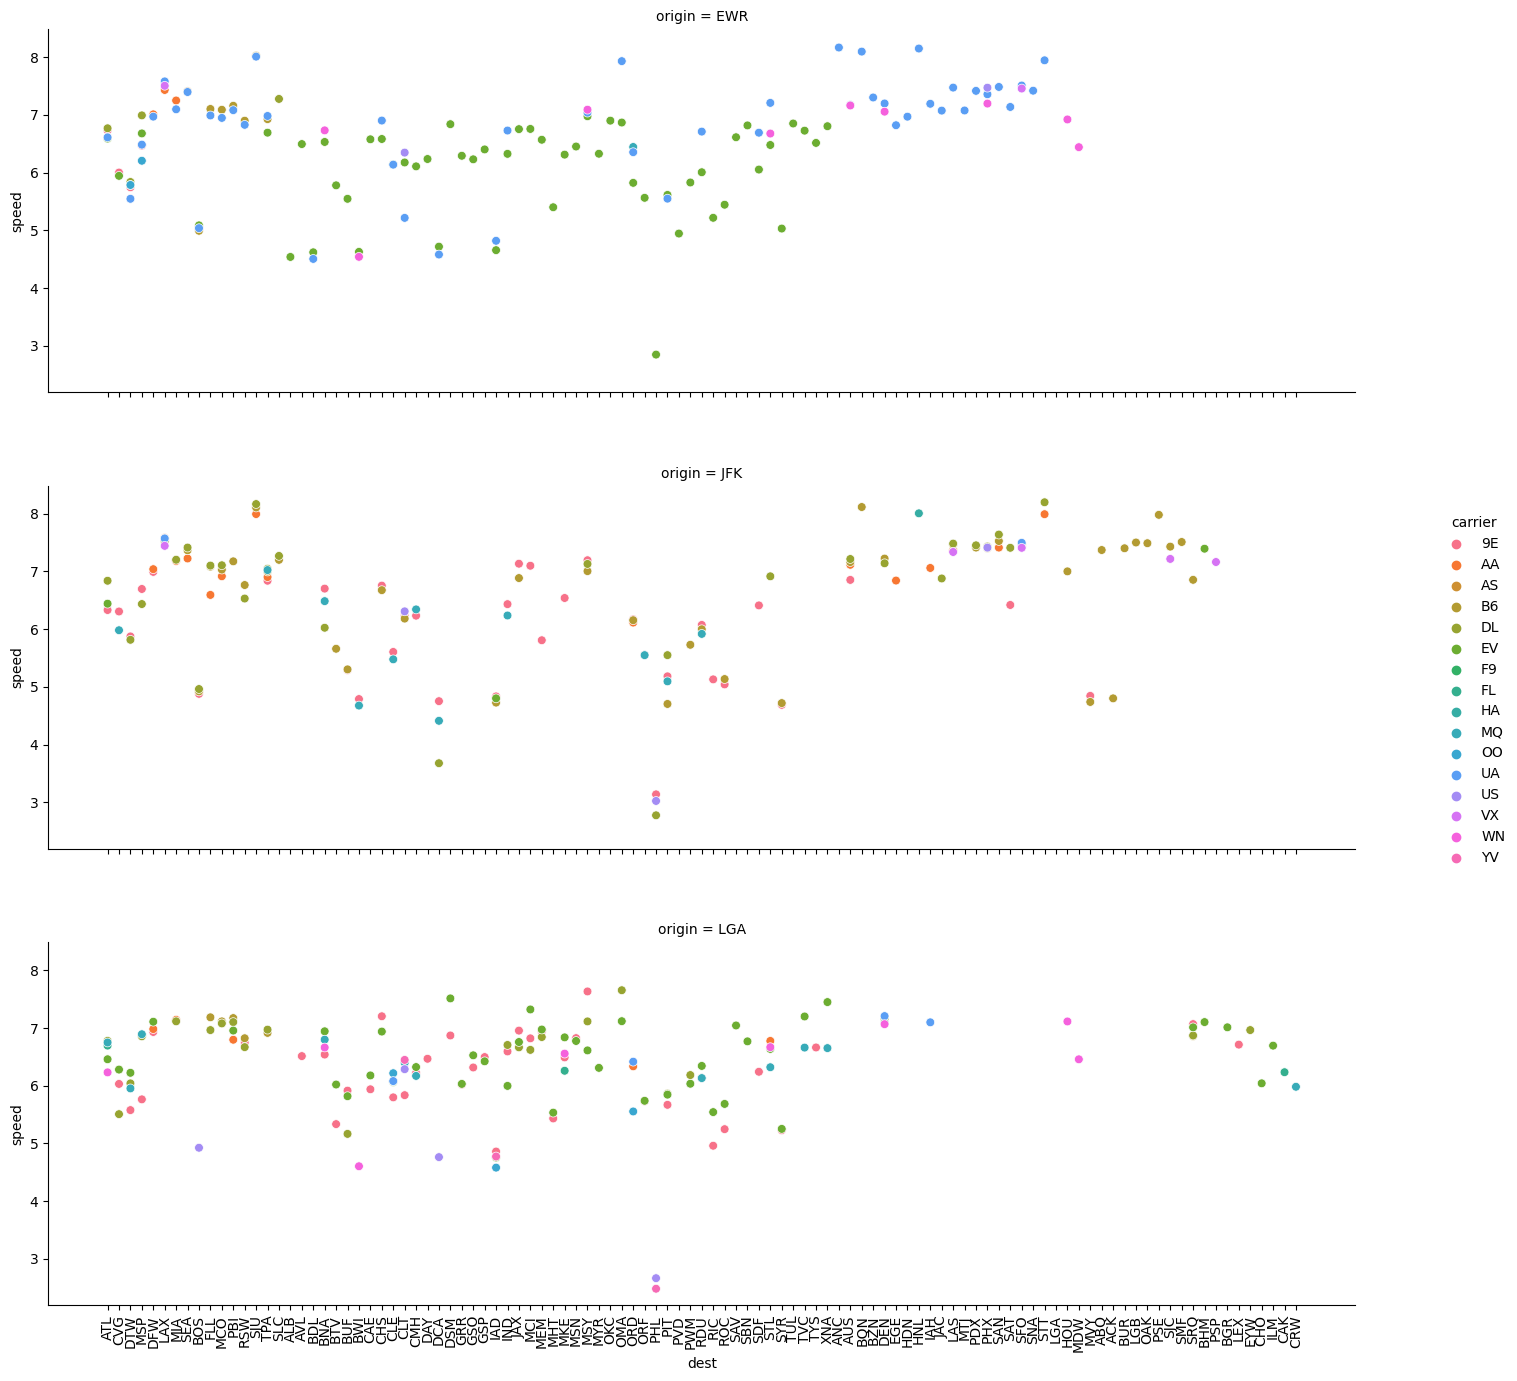

In [129]:
df2=df[['carrier', 'origin' , 'dest','speed']]
df2=df2.groupby(['carrier', 'origin' , 'dest']).mean().reset_index() 
g=sns.relplot(data=df2, x='dest', y='speed', row='origin', hue='carrier', kind='scatter' ,s=40, aspect=3   ) 

for a in g.axes:
    a[0] .set_xlabel('dest') 
plt.xticks(rotation=90) 
g.tight_layout(pad=5)    
plt.show()

In [130]:
from ipywidgets import interact_manual, SelectMultiple
%matplotlib inline
df3=df.groupby(['carrier', 'origin' , 'dest']).mean().reset_index() 

print("Please hold 'ctrl' button and select your desired destinations:")
def plot_speeds(selected ): 
    if selected:
        filtered = df3[df3['dest'].isin(selected)]
        sns.relplot(data=filtered, x='dest', y='speed', col='origin', hue='carrier', kind='scatter', s=100 , alpha=0.5);
        plt.show()
        selected=[]
    else:
        print('Please select at least one .')
    
selected = SelectMultiple(options=df.dest.unique() )

interact_manual(plot_speeds,selected=selected)
        
 

 
 

C:\Users\user\AppData\Local\Temp\ipykernel_26076\2914208657.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3=df.groupby(['carrier', 'origin' , 'dest']).mean().reset_index()


Please hold 'ctrl' button and select your desired destinations:


interactive(children=(SelectMultiple(description='selected', options=('IAH', 'MIA', 'BQN', 'ATL', 'ORD', 'FLL'…

<function __main__.plot_speeds(selected)>